1.Configuración del ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output

2.Obtención de Datos

Precios históricos del bitcoin

In [2]:
# La biblioteca yfinance de Python permite extraer datos financieros de Yahoo Finance.

def importar_base_bitcoin():
  global df_bitcoin
  data = yf.Ticker("BTC-USD").history(period='7d', interval='5m')
  df_bitcoin = pd.DataFrame(data)
  return df_bitcoin

importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-11 00:00:00+00:00,27392.076172,27409.029297,27391.792969,27409.029297,0,0.0,0.0
2023-10-11 00:05:00+00:00,27401.982422,27401.982422,27393.646484,27400.232422,0,0.0,0.0
2023-10-11 00:10:00+00:00,27405.695312,27408.093750,27401.156250,27403.865234,0,0.0,0.0
2023-10-11 00:15:00+00:00,27406.996094,27416.324219,27406.828125,27406.828125,0,0.0,0.0
2023-10-11 00:20:00+00:00,27405.128906,27412.705078,27405.128906,27412.705078,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-17 17:50:00+00:00,28457.806641,28469.263672,28439.742188,28439.742188,13760512,0.0,0.0
2023-10-17 17:55:00+00:00,28435.199219,28450.314453,28435.199219,28450.314453,16038912,0.0,0.0
2023-10-17 18:00:00+00:00,28444.916016,28458.716797,28439.628906,28439.628906,0,0.0,0.0


Indicadores de tendencias

In [3]:
def extraer_tendencias():
  global precio_actual,tendencia
  url = 'https://coinmarketcap.com/'
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'lxml')
  precio_btc = soup.find('div', class_='sc-a0353bbc-0 gDrtaY').get_text()
  precio_btc = precio_btc.replace(',', '')
  precio_btc = precio_btc.replace('$', '')
  precio_actual = float(precio_btc)
  icon = soup.findAll('span', {'class':['sc-d55c02b-0 iwhBxy','sc-97d6d2ca-0 bQjSqS']})[0]
  if 'sc-d55c02b-0 iwhBxy' in ' '.join(icon['class']):
    tendencia = 'alta'
  else:
    tendencia = 'baja'
  variacion = soup.find('span', class_='sc-d55c02b-0 iwhBxy').get_text()
  return [precio_actual, tendencia, variacion]

extraer_tendencias()

[28480.55, 'alta', '0.57%']

3.Limpieza de datos

In [4]:
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df = importar_base_bitcoin()
  df_bitcoin_limpio = df.copy()
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((close >= Q1) & (close < Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return [df_bitcoin_limpio, Q1, Q3]

limpieza_datos()

[                                   Open          High           Low  \
 Datetime                                                              
 2023-10-11 00:25:00+00:00  27413.472656  27413.507812  27405.755859   
 2023-10-11 00:35:00+00:00  27416.724609  27438.466797  27416.724609   
 2023-10-11 00:40:00+00:00  27434.750000  27442.287109  27427.189453   
 2023-10-11 00:45:00+00:00  27436.544922  27436.544922  27432.253906   
 2023-10-11 00:50:00+00:00  27437.820312  27443.441406  27437.820312   
 ...                                 ...           ...           ...   
 2023-10-16 12:25:00+00:00  27805.957031  27817.482422  27801.988281   
 2023-10-16 12:30:00+00:00  27813.205078  27822.703125  27813.205078   
 2023-10-16 12:35:00+00:00  27797.634766  27815.111328  27797.634766   
 2023-10-16 12:40:00+00:00  27809.814453  27810.730469  27794.132812   
 2023-10-16 12:45:00+00:00  27799.863281  27825.962891  27799.863281   
 
                                   Close    Volume  Dividends 

In [5]:
df_new = pd.DataFrame(df_bitcoin_limpio)

In [6]:
df_new

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-11 00:25:00+00:00,27413.472656,27413.507812,27405.755859,27405.755859,1975296,0.0,0.0
2023-10-11 00:35:00+00:00,27416.724609,27438.466797,27416.724609,27438.466797,5985280,0.0,0.0
2023-10-11 00:40:00+00:00,27434.750000,27442.287109,27427.189453,27442.287109,19872768,0.0,0.0
2023-10-11 00:45:00+00:00,27436.544922,27436.544922,27432.253906,27432.253906,2643968,0.0,0.0
2023-10-11 00:50:00+00:00,27437.820312,27443.441406,27437.820312,27443.343750,2116608,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-16 12:25:00+00:00,27805.957031,27817.482422,27801.988281,27801.988281,45682688,0.0,0.0
2023-10-16 12:30:00+00:00,27813.205078,27822.703125,27813.205078,27814.152344,67495936,0.0,0.0
2023-10-16 12:35:00+00:00,27797.634766,27815.111328,27797.634766,27808.234375,34804736,0.0,0.0


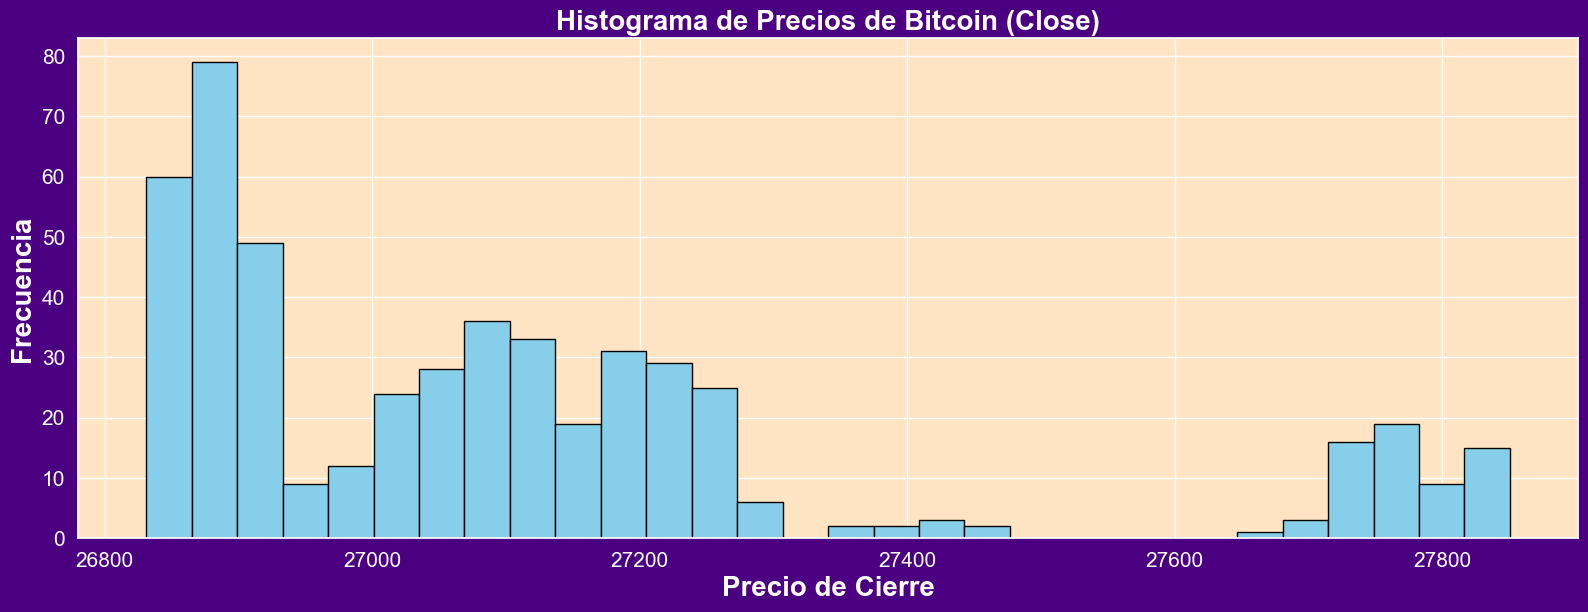

In [7]:
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
fig = plt.figure(figsize=(15,5), facecolor='indigo')
eje = fig.add_axes([0,0,1,1])
eje.tick_params(axis='x', colors='w', labelsize=15)
eje.tick_params(axis='y', colors='w', labelsize=15)

datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

eje.hist(close, bins=30, color='skyblue', edgecolor='black',)
eje.set_title('Histograma de Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
eje.set_facecolor('bisque')
plt.show()


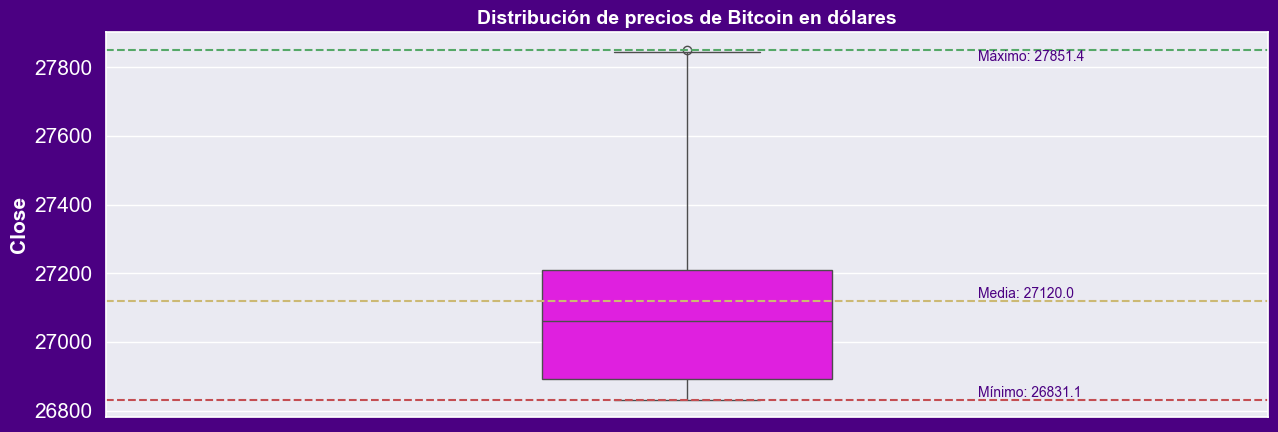

In [8]:
def boxplot1():
  sns.set(style="darkgrid")
  plt.figure(figsize=(15, 5), facecolor='indigo')
  plt.tick_params(axis='x', colors='w', labelsize=15)
  plt.tick_params(axis='y', colors='w', labelsize=15)
 
  boxplot = sns.boxplot(y='Close', data=df_bitcoin_limpio, color='magenta', whis=2, width=0.25)
  plt.ylabel('Close', fontsize=15, color='w', fontweight='bold')
  plt.title('Distribución de precios de Bitcoin en dólares', fontsize=14, color='w',fontweight='bold')

  media = df_bitcoin_limpio['Close'].mean()
  maximo = limpieza_datos()[2]
  minimo = limpieza_datos()[1]

  boxplot.axhline(y=maximo, color='g', linestyle='--')
  boxplot.axhline(y=media, color='y', linestyle='--') 
  boxplot.axhline(y=minimo, color='r', linestyle='--') 
  
  plt.text(x=0.25, y=limpieza_datos()[2], s=f'Máximo: {limpieza_datos()[2].round(1)}', fontsize=10, va='top', color='indigo')
  plt.text(x=0.25, y=media, s=f'Media: {media.round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.text(x=0.25, y=limpieza_datos()[1], s=f'Mínimo: {limpieza_datos()[1].round(1)}', fontsize=10, va='bottom', color='indigo')
  return plt.show()

boxplot1()

4.Toma de desición Compra / Vanta / Espera

In [9]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  media_bitcoin = df_bitcoin_limpio['Close'].mean()
  if ((precio_actual >= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender--'
  elif ((precio_actual < media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar--'
  else:
    algoritmo_decision = 'Esperar--'

  return algoritmo_decision

tomar_decisiones()

'Esperar--'

5.Visualizando los datos / Variación de los últimos 7 días

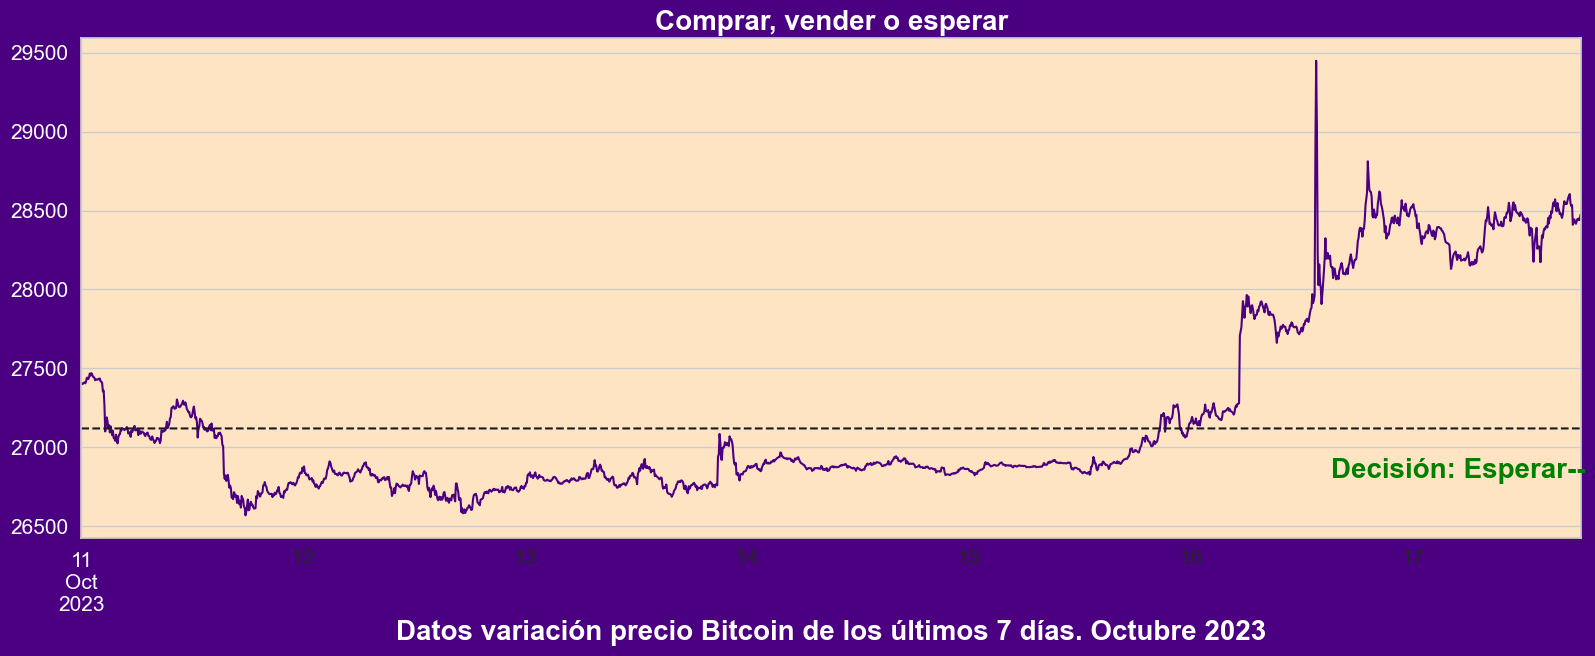

In [10]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  df_bitcoin['Promedio'] = media_bitcoin

  sns.set(style="whitegrid")
  fig = plt.figure(figsize=(15,5), facecolor='indigo')
  eje = fig.add_axes([0,0,1,1])
  
  eje.set_title('Comprar, vender o esperar', fontsize=20,fontweight='bold', color='w')
  df_bitcoin['Close'].plot(legend = None, color = 'indigo')
  df_bitcoin['Promedio'].plot(legend = None, ls='--', color = 'k', fontsize=15)

  eje.set_xlabel('Datos variación precio Bitcoin de los últimos 7 días. Octubre 2023', fontsize=20, fontweight='bold', color='w')
  eje.tick_params(axis='x', colors='w', labelsize=15)
  eje.tick_params(axis='y', colors='w', labelsize=15)
  eje.set_facecolor('bisque')
  eje.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-180, -190), textcoords='offset points', fontsize=20, color='green',fontweight='bold')
  plt.show()
  
visualizacion()

6.Automatizamos el sistema 

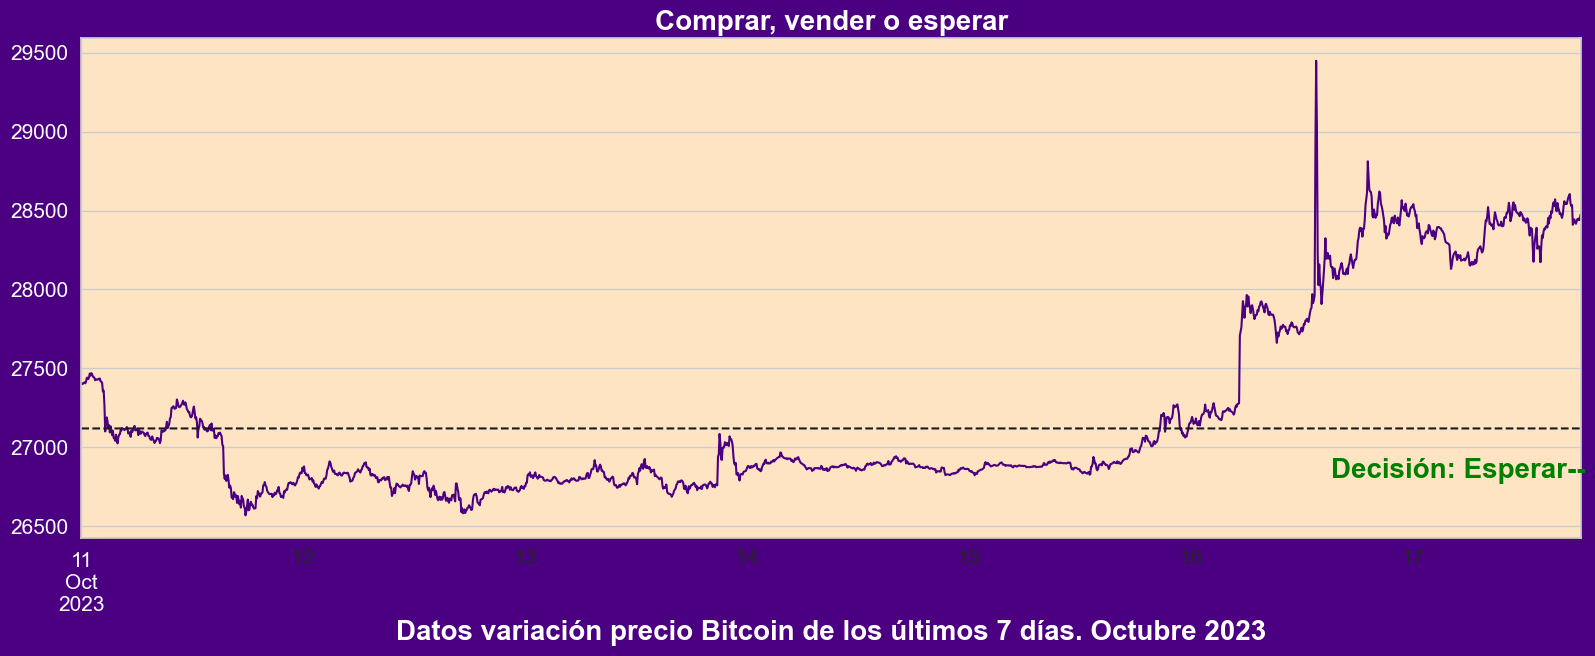

In [11]:
while True:
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)


La toma de datos de variación de precio del bitcoin de los últimos 7 días es un proceso que consiste en recopilar información sobre el precio del bitcoin en un período de tiempo determinado. Esta información se puede utilizar para realizar análisis de tendencias y proyecciones del precio futuro de la moneda.
En nuestro caso para la toma de desiciones de Compra / Venta / Espera según situación y conveniencia.
Web scraping: Este método permite extraer datos de una página web utilizando un script o programa.
Una vez que se han recopilado los datos, se pueden almacenar en una base de datos o en un archivo CSV. Los datos se pueden analizar utilizando una variedad de herramientas y técnicas, como hojas de cálculo, software de análisis de datos y lenguajes de programación.
Una vez que se han recopilado los datos, se pueden analizar para obtener información sobre la variación de precio del bitcoin de los últimos 7 días. Por ejemplo, se puede calcular el rendimiento diario del bitcoin o el porcentaje de variación de precio del bitcoin en un período de tiempo determinado.